In [ ]:
!pip install fcapy==0.1.4.1
!pip install frozendict
!pip install ipynb
!pip install sparselinear
!pip install bitsets
!pip install bitarray

!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [ ]:
#!pip install bitarray
#!pip install bitsets

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, accuracy_score, classification_report

from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice

from fcapy.visualizer import LineVizNx
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = (1,1,1,1)

import neural_lib as nl

# Pipeline

In [5]:
df = pd.read_csv('/content/diabetes.csv')
print(df.shape)
df.sample()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
421,2,94,68,18,76,26.0,0.561,21,0


# Step 0. Binarize the data

In [135]:
df_bin = pd.DataFrame()
#1
step = 8
col='Glucose'
start, finish = 40, 200
df_bin[col[0]+'=0'] = df[col] == 0
for i in range(start, finish, step):
  df_bin['G('+str(i) + ';' + str(i+step) + ']'] = (df[col] >i ) & (df[col] <= (i+step))
#2
step = 5
col = 'BMI'
start, finish = 18, 67
df_bin[col[0]+'=0'] = df[col] == 0
for i in range(start, finish, step):
  df_bin[col[0]+'('+str(i) + ';' + str(i+step) + ']'] = (df[col] >i ) & (df[col] <= (i+step))
#3
step = 6
col = 'Age'
start, finish = 20, 81
for i in range(start, finish, step):
  df_bin[col[0]+'('+str(i) + ';' + str(i+step) + ']'] = (df[col] >i ) & (df[col] <= (i+step))



df_bin['Outcome'] = df['Outcome'] == 1


In [136]:
df_bin.shape

(768, 44)

In [137]:

df_bin['sample_id'] = np.arange(0, df_bin.shape[0], 1).astype(str)
df_bin['id'] = df_bin['sample_id'].apply(lambda x: 'h' + x)
df_bin.drop(columns=['sample_id'], inplace=True)
df_bin=df_bin.set_index('id')
df_bin.sample()

,G=0,G(40;48],G(48;56],G(56;64],G(64;72],G(72;80],G(80;88],G(88;96],G(96;104],G(104;112],...,A(32;38],A(38;44],A(44;50],A(50;56],A(56;62],A(62;68],A(68;74],A(74;80],A(80;86],Outcome
id,,,,,,,,,,,,,,,,,,,,,
h142,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


Split the data to train and test

In [138]:
y_feat = 'Outcome'
df_train, df_test = train_test_split(df_bin, train_size=0.7, random_state=0)

X_train, y_train = df_train.drop(y_feat, axis=1), df_train[y_feat]
X_test, y_test = df_test.drop(y_feat, axis=1), df_test[y_feat]
X_train.sample()



,G=0,G(40;48],G(48;56],G(56;64],G(64;72],G(72;80],G(80;88],G(88;96],G(96;104],G(104;112],...,A(26;32],A(32;38],A(38;44],A(44;50],A(50;56],A(56;62],A(62;68],A(68;74],A(74;80],A(80;86]
id,,,,,,,,,,,,,,,,,,,,,
h155,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False


## Step 1. Build Monotone Concept Lattice

Put binarized data in FormalContext and compute monotone ConceptLattice

In [139]:
%%time 
K_train = FormalContext.from_pandas(X_train)
K_train

CPU times: user 5.7 ms, sys: 0 ns, total: 5.7 ms
Wall time: 5.7 ms


FormalContext (537 objects, 43 attributes, 1611 connections)
    |G=0|G(40;48]|G(48;56]|G(56;64]|G(64;72]|...|A(56;62]|A(62;68]|A(68;74]|A(74;80]|A(80;86]|
h580|   |        |        |        |        |...|        |        |        |        |        |
h418|   |        |        |        |        |...|        |        |        |        |        |
h764|   |        |        |        |        |...|        |        |        |        |        |
h363|   |        |        |        |        |...|        |       X|        |        |        |
h757|   |        |        |        |        |...|        |        |        |        |        |
h636|   |        |        |        |        |...|        |        |        |        |        |
h155|   |        |        |        |        |...|        |        |        |        |        |
h390|   |        |        |        |        |...|        |        |        |        |        |
h761|   |        |        |        |        |...|        |        |        |        

In [140]:
%%time 

L = ConceptLattice.from_context(K_train,algo='Sofia', is_monotone=True)
len(L)

CPU times: user 2min 30s, sys: 865 ms, total: 2min 31s
Wall time: 2min 32s


100

Compute F1 score for each formal concept  (assuming that an object is predicted True if it is in the extent of the concept)

In [141]:
for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['f1_score'] = f1_score(y_train, y_preds)
    c.measures['recall_score'] = recall_score(y_train, y_preds)

Select indices of the best concepts from the lattice

In [146]:

n_concepts = 3
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:n_concepts])
assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

Construct neural network based on concept lattice

In [147]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

Setup visuzalier for the architecture

In [148]:
vis = LineVizNx(node_label_font_size=14, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n')

In [149]:
set(X_train.columns)

{'A(20;26]',
 'A(26;32]',
 'A(32;38]',
 'A(38;44]',
 'A(44;50]',
 'A(50;56]',
 'A(56;62]',
 'A(62;68]',
 'A(68;74]',
 'A(74;80]',
 'A(80;86]',
 'B(18;23]',
 'B(23;28]',
 'B(28;33]',
 'B(33;38]',
 'B(38;43]',
 'B(43;48]',
 'B(48;53]',
 'B(53;58]',
 'B(58;63]',
 'B(63;68]',
 'B=0',
 'G(104;112]',
 'G(112;120]',
 'G(120;128]',
 'G(128;136]',
 'G(136;144]',
 'G(144;152]',
 'G(152;160]',
 'G(160;168]',
 'G(168;176]',
 'G(176;184]',
 'G(184;192]',
 'G(192;200]',
 'G(40;48]',
 'G(48;56]',
 'G(56;64]',
 'G(64;72]',
 'G(72;80]',
 'G(80;88]',
 'G(88;96]',
 'G(96;104]',
 'G=0'}

In [150]:
descr = {'G(192;200]'}

traced = cn.trace_description(descr, include_targets=False)

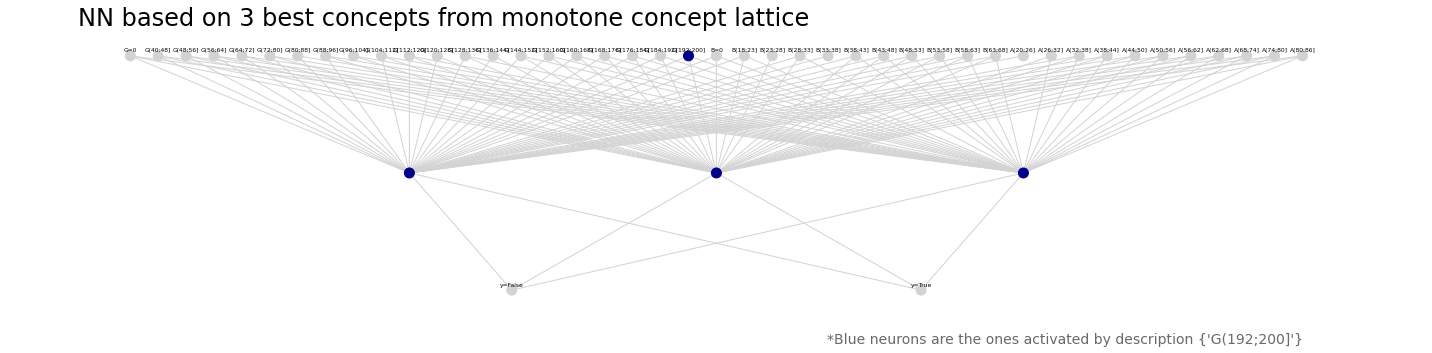

In [160]:
fig, ax = plt.subplots(figsize=(20,5))

vis.draw_poset(
    cn.poset, ax=ax, 
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced else 'lightgray' for el_i in range(len(cn.poset))
                ],
               node_size=100,
               node_label_font_size=6
)
plt.title(f'NN based on '+str(n_concepts)+' best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis.mover.posx), min(vis.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.savefig('nn_g_b_a.png')
plt.show()

Now fit the network

In [152]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))
cn.fit(X_train, y_train,  n_epochs = 2000)

y_pred = cn.predict(X_test).numpy()
print('Class prediction', y_pred[:10])
y_proba = cn.predict_proba(X_test).detach().numpy()
print('Class prediction with probabilities', y_proba[:10])
print('True class', y_test.values[:10])

print('Recall score:', recall_score(y_test.values.astype('int'), y_pred))
print('F1     score:', f1_score(y_test.values.astype('int'), y_pred))
print('Accuracy score:', accuracy_score(y_test.values.astype('int'), y_pred))

Class prediction [0 0 0 1 0 0 1 1 0 1]
Class prediction with probabilities [[5.28354287e-01 4.71645743e-01]
 [9.99423146e-01 5.76919061e-04]
 [9.99984622e-01 1.54281151e-05]
 [1.07615486e-01 8.92384529e-01]
 [9.96980727e-01 3.01930122e-03]
 [9.99987960e-01 1.19969636e-05]
 [4.00160253e-01 5.99839747e-01]
 [1.07615486e-01 8.92384529e-01]
 [9.99856591e-01 1.43392710e-04]
 [3.62107635e-01 6.37892365e-01]]
True class [ True False False  True False False  True  True False False]
Recall score: 0.44594594594594594
F1     score: 0.5238095238095238
Accuracy score: 0.7402597402597403


In [153]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))
cn.fit(X_train, y_train,  n_epochs = 5000)

y_pred = cn.predict(X_test).numpy()
print('Class prediction', y_pred[:10])
y_proba = cn.predict_proba(X_test).detach().numpy()
print('Class prediction with probabilities', y_proba[:10])
print('True class', y_test.values[:10])

print('Recall score:', recall_score(y_test.values.astype('int'), y_pred))
print('F1     score:', f1_score(y_test.values.astype('int'), y_pred))
print('Accuracy score:', accuracy_score(y_test.values.astype('int'), y_pred))

Class prediction [0 0 0 1 0 0 1 1 0 1]
Class prediction with probabilities [[9.99896765e-01 1.03234335e-04]
 [9.99999762e-01 2.94967123e-07]
 [1.00000000e+00 4.67579930e-08]
 [3.53021362e-11 1.00000000e+00]
 [9.99941826e-01 5.81180320e-05]
 [1.00000000e+00 8.46674197e-09]
 [2.01156636e-05 9.99979854e-01]
 [8.98629000e-18 1.00000000e+00]
 [1.00000000e+00 8.56772164e-09]
 [1.20688252e-01 8.79311800e-01]]
True class [ True False False  True False False  True  True False False]
Recall score: 0.4594594594594595
F1     score: 0.5151515151515151
Accuracy score: 0.7229437229437229


In [154]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))
cn.fit(X_train, y_train,  n_epochs = 10000)

y_pred = cn.predict(X_test).numpy()
print('Class prediction', y_pred[:10])
y_proba = cn.predict_proba(X_test).detach().numpy()
print('Class prediction with probabilities', y_proba[:10])
print('True class', y_test.values[:10])

print('Recall score:', recall_score(y_test.values.astype('int'), y_pred))
print('F1     score:', f1_score(y_test.values.astype('int'), y_pred))
print('Accuracy score:', accuracy_score(y_test.values.astype('int'), y_pred))

Class prediction [0 0 0 1 0 0 0 1 0 1]
Class prediction with probabilities [[1.0000000e+00 2.7373082e-19]
 [1.0000000e+00 1.9375592e-25]
 [1.0000000e+00 1.1064891e-31]
 [3.0063290e-22 1.0000000e+00]
 [1.0000000e+00 2.7813977e-14]
 [1.0000000e+00 4.2929189e-29]
 [9.9982762e-01 1.7229943e-04]
 [2.2950832e-29 1.0000000e+00]
 [1.0000000e+00 1.4004577e-41]
 [3.8422531e-05 9.9996161e-01]]
True class [ True False False  True False False  True  True False False]
Recall score: 0.44594594594594594
F1     score: 0.515625
Accuracy score: 0.7316017316017316


The best result were 2 000 epochs

In [159]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))
cn.fit(X_train, y_train,  n_epochs = 2000)

y_pred = cn.predict(X_test).numpy()
print('Class prediction', y_pred[:10])
y_proba = cn.predict_proba(X_test).detach().numpy()
print('Class prediction with probabilities', y_proba[:10])
print('True class', y_test.values[:10])

print('Recall score:', recall_score(y_test.values.astype('int'), y_pred))
print('F1     score:', f1_score(y_test.values.astype('int'), y_pred))
print('Accuracy score:', accuracy_score(y_test.values.astype('int'), y_pred))

Class prediction [1 0 0 1 0 0 0 1 0 1]
Class prediction with probabilities [[4.0145043e-01 5.9854954e-01]
 [9.9929619e-01 7.0381584e-04]
 [9.9998808e-01 1.1899552e-05]
 [9.8012954e-02 9.0198708e-01]
 [9.9847716e-01 1.5228972e-03]
 [9.9999571e-01 4.3215732e-06]
 [5.0679141e-01 4.9320856e-01]
 [9.8012954e-02 9.0198708e-01]
 [9.9863487e-01 1.3650487e-03]
 [2.3684967e-01 7.6315033e-01]]
True class [ True False False  True False False  True  True False False]
Recall score: 0.44594594594594594
F1     score: 0.532258064516129
Accuracy score: 0.7489177489177489


In [161]:
edge_weights = cn.edge_weights_from_network()

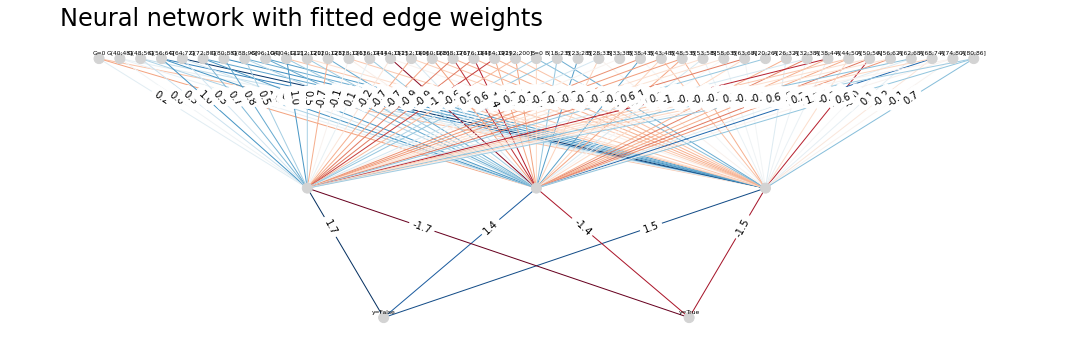

In [163]:
import networkx as nx

fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax, 
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
    
               node_size=100,
               node_label_font_size=6
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_g_b_a.png')
plt.show()